In [1]:
import importlib

import einops
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle as pk
import tensorflow as tf
import tqdm

from sklearn.decomposition import IncrementalPCA
from pycocotools.coco import COCO
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.data.experimental import ignore_errors
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import TextVectorization

import utils.dataset
importlib.reload(utils.dataset)

from utils.dataset import setup_trainval_sets, setup_test_set, standardize, load_dataset, load_image

2025-01-24 16:39:56.131105: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 16:39:56.143416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737733196.155984   45336 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737733196.159699   45336 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 16:39:56.174668: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
TRAIN_ANNOTATIONS_PATH = "dataset/annotations_trainval2014/captions_train2014.json"
VAL_ANNOTATIONS_PATH = "dataset/annotations_trainval2014/captions_val2014.json"

IMAGE_SHAPE=(224, 224, 3)
VOCABULARY_SIZE = 10000

In [4]:
coco_train = COCO(TRAIN_ANNOTATIONS_PATH)
coco_val = COCO(VAL_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [5]:
image_id = coco_train.getImgIds()[1000]
ann_ids = coco_train.getAnnIds(imgIds=image_id)
anns = coco_train.loadAnns(ann_ids)

print(f"Captions for image {image_id}:")
for ann in anns:
    print(ann['caption'])

Captions for image 429437:
a table topped with bowls of food and a glass of water.
Dishes of prepared food laid out on a table with empty glasses and plates
Several bowls of food next to a stack of plates.
Prepared Asian foods sit on a table with dinner plates and glasses.
A black table holds white bowls and plates and different foods as water glasses also sit on the table.


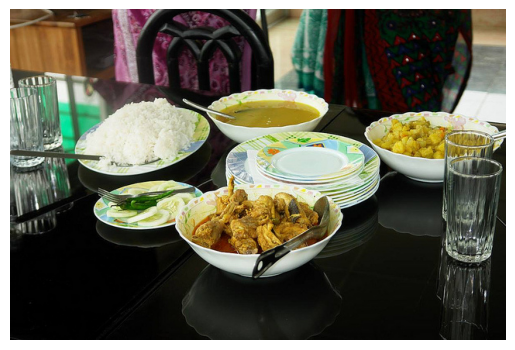

In [6]:
file_name = "COCO_train2014_000000429437.jpg"
img_path = f"dataset/train2014/{file_name}"
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
dataset_train = setup_trainval_sets("train2014", coco_train)
dataset_val = setup_trainval_sets("val2014", coco_val)

I0000 00:00:1737733209.290223   45336 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
for img_path, caption in dataset_train.take(1):
    print("Image path:", img_path.numpy())
    print("Caption:", caption.numpy())

for img_path, caption in dataset_val.take(1):
    print("Image path:", img_path.numpy())
    print("Caption:", caption.numpy())


Image path: b'dataset/train2014/COCO_train2014_000000057870.jpg'
Caption: b'A restaurant has modern wooden tables and chairs.'
Image path: b'dataset/val2014/COCO_val2014_000000391895.jpg'
Caption: b'A man with a red helmet on a small moped on a dirt road. '
Image path: b'dataset/test2014/COCO_test2014_000000523573.jpg'


2025-01-24 16:40:13.997195: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-24 16:40:14.002109: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# Image Encoder Layer (Pretrained MobileNetV3Small Network) ##########ResNet50V2

mobilenet = MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False, # Exclude the classification head
    weights='imagenet',
    pooling=None
)

mobilenet.trainable=False

In [10]:
# Tokenizer

tokenizer = TextVectorization(
  max_tokens=VOCABULARY_SIZE,
  standardize=standardize,
  output_sequence_length=50,
  ragged=True
)

In [11]:
tokenizer.adapt(dataset_train.map(lambda img_path, caption: caption).batch(1024))

2025-01-24 16:40:28.596943: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
tokenizer.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('a'),
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('on'),
 np.str_('of'),
 np.str_('the'),
 np.str_('in'),
 np.str_('with')]

In [13]:
t = tokenizer([['a large wooden cat'], ['a table on a hill']])
t

<tf.RaggedTensor [[3, 2, 29, 99, 51, 4], [3, 2, 24, 5, 2, 224, 4]]>

In [14]:
# Mappings for words to indices and indices to words

word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary()
)

index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True
)

In [15]:
w = index_to_word(t)
w.to_list()

tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a large wooden cat [END]',
       b'[START] a table on a hill [END]'], dtype=object)

In [16]:
# Function to extend each caption to an image (duplicate)

def split_captions_on_images(images, captions):
    # Parse captions (b: batch size, c: captions)
    caption_shape = einops.parse_shape(captions, 'b c')
    # Flatten captions to match repeated images
    captions = einops.rearrange(captions, 'b c -> (b c)')
    # Repeat the images along the caption dimension
    images = einops.repeat(images, 'b ... -> (b c) ...', c=caption_shape['c'])

    return images, captions

In [17]:
def prepare_text(images, texts):
    tokens = tokenizer(texts)

    # Shift tokens for input and labels
    input_tokens = tokens[..., :-1]  # All tokens except the last one (input for prediction)
    label_tokens = tokens[..., 1:]   # All tokens except the first one (target output)

    return (images, input_tokens), label_tokens

In [18]:
def process_image_and_caption(img_path, caption):
    # Load the image and tokenize the caption
    image = load_image(img_path)
    tokenized_caption = tokenizer(caption)
    return image, tokenized_caption


def to_tensor(inputs, labels):
    (images, input_tokens), label_tokens = inputs, labels
    return (images, input_tokens.to_tensor()), label_tokens.to_tensor()


def prepare_dataset(dataset: Dataset, tokenizer, batch_size=256, shuffle_buffer=1000):
    dataset = (
        dataset
        .shuffle(10000)
        .map(process_image_and_caption, num_parallel_calls=AUTOTUNE)
        .apply(ignore_errors())
        .batch(batch_size)
    )

    return (
        dataset
        .map(split_captions_on_images, AUTOTUNE)
        .unbatch()
        .shuffle(shuffle_buffer)
        .batch(batch_size)
        .map(prepare_text, AUTOTUNE)
        .map(to_tensor, AUTOTUNE)
    )

In [22]:
train_ds = prepare_dataset(dataset_train, tokenizer)
train_ds.element_spec

val_ds = prepare_dataset(dataset_val, tokenizer)
val_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [19]:
def gen(dataset, image_model):
    for (images, captions) in tqdm.tqdm(dataset):
        feature_maps = image_model(images)
        yield feature_maps, captions


def save_dataset(dataset, save_path, image_model, shards=10, batch_size=256):
    dataset = (
        dataset
        .map(lambda img_path, caption: (load_image(img_path, IMAGE_SHAPE), caption))
        .apply(ignore_errors())
        .batch(batch_size)
    )

    new_dataset = Dataset.from_generator(
        lambda: gen(dataset, image_model),
        output_signature=(
            tf.TensorSpec(shape=image_model.output_shape, dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.string)
        )
    )

    new_dataset = (
        new_dataset
        .map(prepare_text, num_parallel_calls=AUTOTUNE)
        .unbatch()
        .shuffle(1000)
    )

    def shard_func(i, item):
        return i % shards

    new_dataset.enumerate().save(save_path, shard_func=shard_func)

In [20]:
save_dataset(dataset_train, "processed_dataset/train2014_full", mobilenet)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


0it [00:00, ?it/s]I0000 00:00:1737733267.440095   46221 cuda_dnn.cc:529] Loaded cuDNN version 90600
1618it [05:25,  4.98it/s]


In [21]:
save_dataset(dataset_val, "processed_dataset/val2014_full", mobilenet)

792it [02:30,  5.26it/s]


In [22]:
dataset_train_loaded = load_dataset("processed_dataset/train2014_full")

In [23]:
# Test if load_dataset works

for feature_map, caption in dataset_train_loaded.take(1):
    print("feature_map:", feature_map)
    print("Caption:", caption)

feature_map: (<tf.Tensor: shape=(256, 7, 7, 576), dtype=float32, numpy=
array([[[[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         ...,
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]],

        [[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-0.000

### Old `PCA` implementation before we decided not to use it

In [23]:
def fit_incremental_pca(dataset, image_model, n_components, batch_size=256):
    ipca = IncrementalPCA(n_components=n_components)
    for (img_paths, _) in tqdm.tqdm(dataset.batch(batch_size)):
        images = tf.stack([load_image(img_path) for img_path in img_paths])
        feature_maps = image_model(images)
        flat_feature_maps = tf.reshape(feature_maps, (feature_maps.shape[0], -1))
        ipca.partial_fit(flat_feature_maps.numpy())  # Update PCA incrementally

    return ipca

In [24]:
ipca = fit_incremental_pca(dataset_train, n_components=None, image_model=mobilenet, batch_size=512)

100%|██████████| 809/809 [1:18:05<00:00,  5.79s/it]


In [27]:
with open('pca.pkl', 'wb') as pickle_file:
    pk.dump(ipca, pickle_file)

In [23]:
with open('pca.pkl', 'rb') as pickle_file:
    ipca_loaded = pk.load(pickle_file)

In [25]:
# Test if loaded PCA returns the same explained_variance_ratio to ensure saving + loading of PCA functions properly

ipca_loaded.explained_variance_ratio_

array([0.01391412, 0.01189686, 0.01130619, 0.00954843, 0.00902375,
       0.00814597, 0.00697649, 0.00631148, 0.00605322, 0.00517148,
       0.00467706, 0.00444539, 0.00433777, 0.00406771, 0.00390867,
       0.00359883, 0.00349329, 0.00339522, 0.00337565, 0.00333893,
       0.00319498, 0.00299381, 0.00297996, 0.00290016, 0.00288083,
       0.00276312, 0.00265909, 0.0026282 , 0.00258809, 0.00256291,
       0.00253684, 0.00247908, 0.00231504, 0.00229373, 0.0022372 ,
       0.0021998 , 0.00216667, 0.00212811, 0.00205204, 0.00203402,
       0.00197391, 0.00195909, 0.00193882, 0.00190805, 0.00187021,
       0.00182072, 0.00179212, 0.00177121, 0.00174608, 0.00173328,
       0.00172109, 0.00166572, 0.00166132, 0.00164618, 0.00161382,
       0.00160867, 0.0015884 , 0.00156359, 0.00154557, 0.00152736,
       0.00150448, 0.0014969 , 0.00148716, 0.00146321, 0.00144258,
       0.00142973, 0.00142003, 0.0013979 , 0.00138244, 0.00137501,
       0.00135909, 0.00133967, 0.00133425, 0.00132111, 0.00130

In [25]:
explained_variance_ratio = ipca.explained_variance_ratio_

In [28]:
explained_variance_ratio

array([0.01391412, 0.01189686, 0.01130619, 0.00954843, 0.00902375,
       0.00814597, 0.00697649, 0.00631148, 0.00605322, 0.00517148,
       0.00467706, 0.00444539, 0.00433777, 0.00406771, 0.00390867,
       0.00359883, 0.00349329, 0.00339522, 0.00337565, 0.00333893,
       0.00319498, 0.00299381, 0.00297996, 0.00290016, 0.00288083,
       0.00276312, 0.00265909, 0.0026282 , 0.00258809, 0.00256291,
       0.00253684, 0.00247908, 0.00231504, 0.00229373, 0.0022372 ,
       0.0021998 , 0.00216667, 0.00212811, 0.00205204, 0.00203402,
       0.00197391, 0.00195909, 0.00193882, 0.00190805, 0.00187021,
       0.00182072, 0.00179212, 0.00177121, 0.00174608, 0.00173328,
       0.00172109, 0.00166572, 0.00166132, 0.00164618, 0.00161382,
       0.00160867, 0.0015884 , 0.00156359, 0.00154557, 0.00152736,
       0.00150448, 0.0014969 , 0.00148716, 0.00146321, 0.00144258,
       0.00142973, 0.00142003, 0.0013979 , 0.00138244, 0.00137501,
       0.00135909, 0.00133967, 0.00133425, 0.00132111, 0.00130

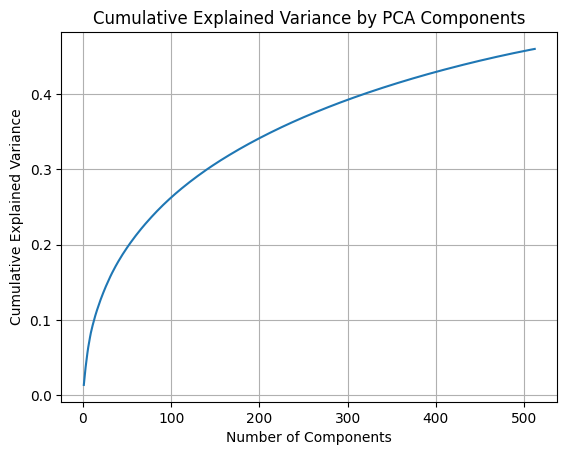

In [31]:
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by PCA Components")
plt.grid()
plt.show()

In [ ]:
# Test if loaded PCA returns the same transformation to ensure saving + loading of PCA functions properly

for img_path, caption in dataset_train.take(1):
    print("Image Path:", img_path.numpy().decode("utf-8"))  # Convert Tensor to string
    print("Caption:", caption.numpy().decode("utf-8"))  # If captions are also string Tensors

    image = load_image(img_path)
    image = tf.expand_dims(image, axis=0)
    feature_maps = mobilenet(image)
    flat_feature_maps = tf.reshape(feature_maps, (feature_maps.shape[0], -1))
    pca_features = ipca.transform(flat_feature_maps.numpy())
    pca_loaded_features = ipca_loaded.transform(flat_feature_maps.numpy())


Image Path: dataset/train2014/COCO_train2014_000000057870.jpg
Caption: A restaurant has modern wooden tables and chairs.


In [36]:
pca_features

array([[-4.42745636e+01,  1.26873926e+01,  3.18339196e+00,
         3.13316732e+01, -3.11712547e+00,  1.33607430e+01,
        -1.88789990e+01, -5.43180026e+00,  2.08571733e+01,
        -1.51874432e+01,  5.08103271e+00,  1.11278162e+01,
        -3.37635853e+01,  2.06242706e+01,  4.08657191e+01,
        -2.25360150e+01, -5.56579345e+00, -3.31519757e+00,
         1.47626363e+01,  2.07837869e+01, -6.22914128e+00,
         1.12262883e+01,  1.03700237e+01,  1.47788263e+00,
         9.45854441e+00,  3.21284008e+00, -6.09489504e+00,
         9.24717900e+00,  8.62014713e+00,  1.49742141e+01,
         3.91441339e+00,  6.82428690e-01,  9.30465424e+00,
         1.78112195e+01, -1.55294019e+01, -1.10148626e+00,
         6.63236255e+00,  1.64645218e+00,  1.59484593e+01,
         1.56350276e+01, -1.44186767e+01,  4.50484095e+00,
        -3.94868689e+00,  7.68325124e+00,  1.81447949e+00,
        -2.12903139e+01,  8.24281788e+00,  1.12580813e+01,
        -3.95394824e+00, -8.81578764e+00,  3.06794908e+0

In [48]:
pca_loaded_features

array([[-4.42745636e+01,  1.26873926e+01,  3.18339196e+00,
         3.13316732e+01, -3.11712547e+00,  1.33607430e+01,
        -1.88789990e+01, -5.43180026e+00,  2.08571733e+01,
        -1.51874432e+01,  5.08103271e+00,  1.11278162e+01,
        -3.37635853e+01,  2.06242706e+01,  4.08657191e+01,
        -2.25360150e+01, -5.56579345e+00, -3.31519757e+00,
         1.47626363e+01,  2.07837869e+01, -6.22914128e+00,
         1.12262883e+01,  1.03700237e+01,  1.47788263e+00,
         9.45854441e+00,  3.21284008e+00, -6.09489504e+00,
         9.24717900e+00,  8.62014713e+00,  1.49742141e+01,
         3.91441339e+00,  6.82428690e-01,  9.30465424e+00,
         1.78112195e+01, -1.55294019e+01, -1.10148626e+00,
         6.63236255e+00,  1.64645218e+00,  1.59484593e+01,
         1.56350276e+01, -1.44186767e+01,  4.50484095e+00,
        -3.94868689e+00,  7.68325124e+00,  1.81447949e+00,
        -2.12903139e+01,  8.24281788e+00,  1.12580813e+01,
        -3.95394824e+00, -8.81578764e+00,  3.06794908e+0

In [29]:
def gen_for_pca(dataset, image_model):
    for (images, captions) in tqdm.tqdm(dataset):
        feature_maps = image_model(images)
        flat_feature_maps = tf.reshape(feature_maps, (feature_maps.shape[0], -1))
        pca_features = ipca_loaded.transform(flat_feature_maps.numpy())  # Apply PCA
        
        yield pca_features, captions


def save_dataset_with_pca(dataset, save_path, image_model, shards=10, batch_size=256, n_components=512):
    dataset = (
        dataset
        .map(lambda img_path, caption: (load_image(img_path), caption))
        .apply(ignore_errors())
        .shuffle(1000)
        .batch(batch_size)
    )

    new_dataset = Dataset.from_generator(
        lambda: gen_for_pca(dataset, image_model),
        output_signature=(
            tf.TensorSpec(shape=(None, n_components), dtype=tf.float32), # Variable batch_size, as the last batch can be smaller than 256
            tf.TensorSpec(shape=(None,), dtype=tf.string)
        )
    )

    new_dataset = (
        new_dataset
        .map(prepare_text, num_parallel_calls=AUTOTUNE)
        .unbatch()
        .shuffle(1000)
    )

    def shard_func(i, item):
        return i % shards

    new_dataset.enumerate().save(save_path, shard_func=shard_func)

In [30]:
# Save dataset_train with PCA in shards
save_dataset_with_pca(dataset_train, "processed_dataset/train2014_cache", mobilenet, n_components=512)

1618it [07:00,  3.85it/s]


In [31]:
# Save dataset_val with PCA in shards
save_dataset_with_pca(dataset_val, "processed_dataset/val2014_cache", mobilenet, n_components=512)

792it [03:46,  3.50it/s]
